# Описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

data_arc_new.csv — данные об электродах;

data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

data_gas_new.csv — данные о продувке сплава газом;

data_temp_new.csv — результаты измерения температуры;

data_wire_new.csv — данные о проволочных материалах (объём);

data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

# Цель

Построить модель, которая предскажет температуру стали.

# План работы

1. Описание проекта, задачи


2. Изучение и подготовка данных:

   2.1 Выгрузка данных
   
   2.2 Инициализация данных
   
   2.3 Анализ данных
   
   2.4 Описание данных
   
  
3. Предобработка данных:

   3.1 Проверка типов данных
   
   3.2 Работа с проспусками
   
   
4. Подготовка данных:

   4.1 Проверка на мультиколлинеарность
   
   4.2 Формирование итоговых датафреймов
   
   4.3 Формирование целевого и остальных признаков
   
   4.4 Формирвоание обучающих, валид и тест выборок
   
   
5. Обучение моделей:

   5.1 3-4 модели
   
   
6. Тестирование моделей:

   6.1 Анализ важности факторов
   
7. Итоговый вывод

In [1]:
!pip install scikit-learn==1.1.3
!pip install lightgbm

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import time
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

# 1. Изучение и подготовка данных

# Данные об электродах

In [3]:
data_arc=pd.read_csv('/datasets/data_arc_new.csv')

In [4]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [8]:
#посмотрим количество итераций в партий
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

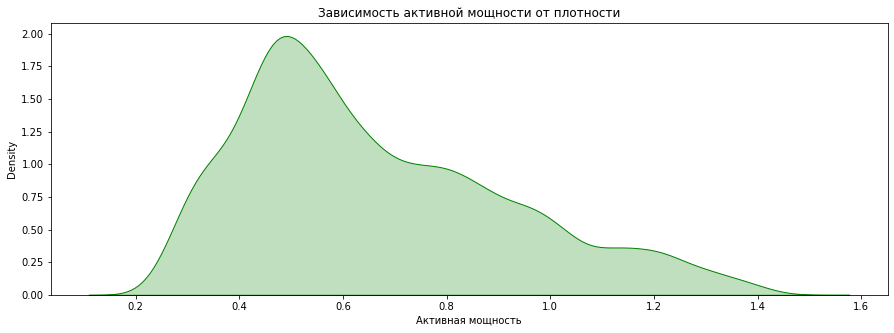

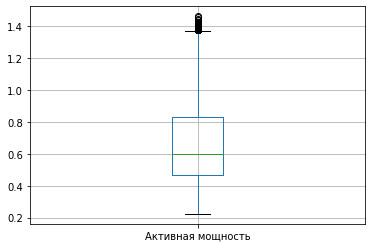

In [9]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(data_arc['Активная мощность'],color='g', legend=True,shade=True)
plt.title('Зависимость активной мощности от плотности')
plt.show()
fig2 =data_arc.boxplot('Активная мощность')
plt.show()

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64

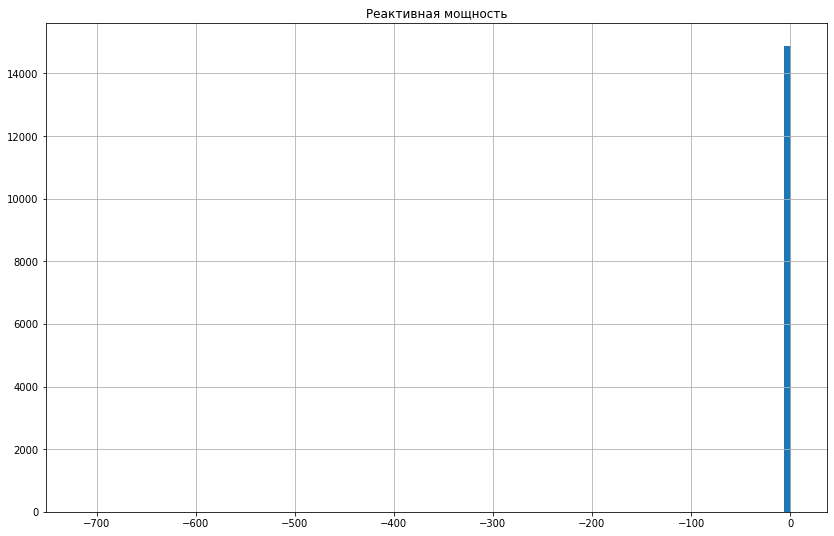

In [10]:
# посмотрим ее значения Реактивной мощности и график
display(data_arc['Реактивная мощность'].describe())
data_arc['Реактивная мощность'].hist(bins=100, figsize=(14,9))
plt.title('Реактивная мощность');
plt.show()

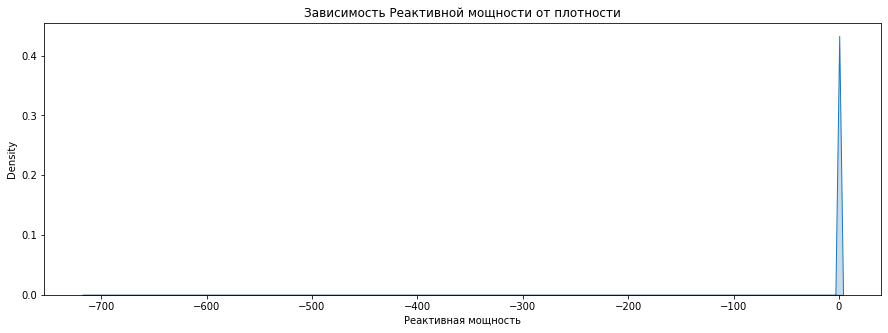

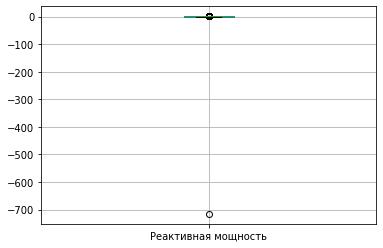

In [11]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(data_arc['Реактивная мощность'], legend=True,shade=True)
plt.title('Зависимость Реактивной мощности от плотности')
plt.show()
fig2 =data_arc.boxplot('Реактивная мощность')
plt.show()

Необходимо убрать аномалии в данных

In [12]:
data_arc =data_arc[data_arc['Реактивная мощность'] >= 0]

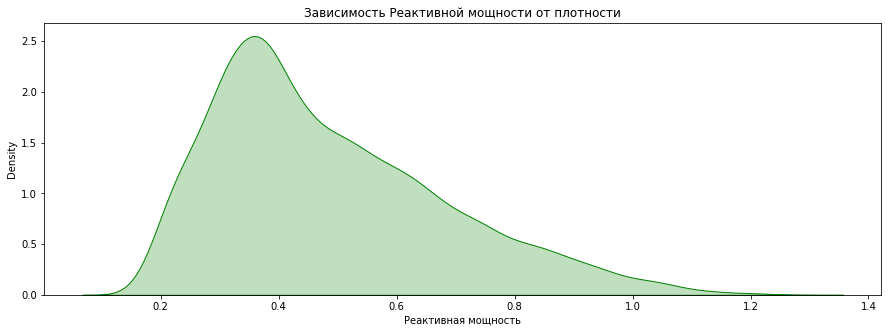

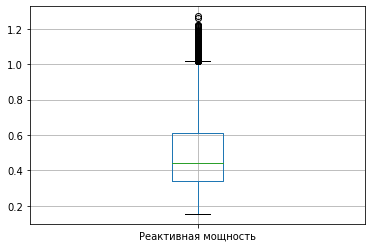

In [13]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(data_arc['Реактивная мощность'], color='g',legend=True,shade=True)
plt.title('Зависимость Реактивной мощности от плотности')
plt.show()
fig2 =data_arc.boxplot('Реактивная мощность')
plt.show()

Корреляция Активной и Реактивной мощности

In [14]:
print('Корреляция Активной и Реактивной мощности', data_arc['Активная мощность'].corr(data_arc['Реактивная мощность']))

Корреляция Активной и Реактивной мощности 0.9663734456187295


# Данные о подаче сыпучих материалов (объём)

In [15]:
data_bulk=pd.read_csv('/datasets/data_bulk_new.csv')

In [16]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [17]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [18]:
data_bulk['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

В данной таблице key уникален в каждой строке

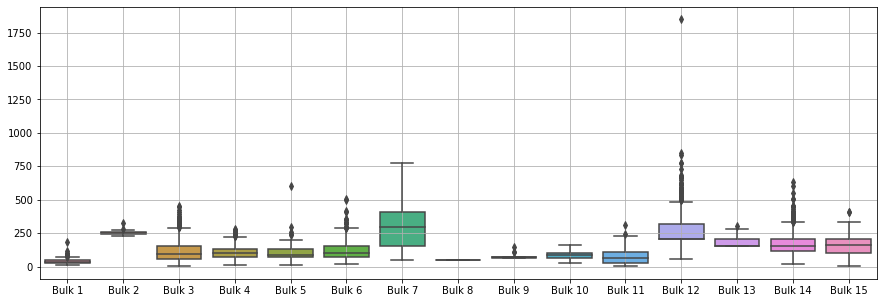

In [19]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_bulk.drop('key',axis=1))
plt.grid();

Единичное значение объема материала под номером 5 и 12 похож на выброс, на данном этапе оставим значение без изменения.

Типы данных в порядке, дубликатов нет

Имеются пропуcки, которые есть смысл заполнить 0, т.к. показывает, что не происходило добавление компонента

# Данные о подаче сыпучих материалов (время)

In [20]:
data_bulk_time=pd.read_csv('/datasets/data_bulk_time_new.csv')

In [21]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [22]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


необходимо изменить формат времени, пропуски заменить на 0

In [23]:
data_bulk_time['Bulk 1'] = pd.to_datetime(data_bulk_time['Bulk 1'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 2'] = pd.to_datetime(data_bulk_time['Bulk 2'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 3'] = pd.to_datetime(data_bulk_time['Bulk 3'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 4'] = pd.to_datetime(data_bulk_time['Bulk 4'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 5'] = pd.to_datetime(data_bulk_time['Bulk 5'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 6'] = pd.to_datetime(data_bulk_time['Bulk 6'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 7'] = pd.to_datetime(data_bulk_time['Bulk 7'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 8'] = pd.to_datetime(data_bulk_time['Bulk 8'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 9'] = pd.to_datetime(data_bulk_time['Bulk 9'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 10'] = pd.to_datetime(data_bulk_time['Bulk 10'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 11'] = pd.to_datetime(data_bulk_time['Bulk 11'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 12'] = pd.to_datetime(data_bulk_time['Bulk 12'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 13'] = pd.to_datetime(data_bulk_time['Bulk 13'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 14'] = pd.to_datetime(data_bulk_time['Bulk 14'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time['Bulk 15'] = pd.to_datetime(data_bulk_time['Bulk 15'], format='%Y-%m-%dT%H:%M:%S')

In [24]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [25]:
data_bulk_time['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

key не содержит повторов

# Данные о продувке сплава газом

In [26]:
data_gas=pd.read_csv('/datasets/data_gas_new.csv')

In [27]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [28]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [29]:
data_gas['key'].value_counts()

2049    1
3135    1
3115    1
1070    1
3119    1
       ..
2596    1
549     1
2600    1
553     1
2047    1
Name: key, Length: 3239, dtype: int64

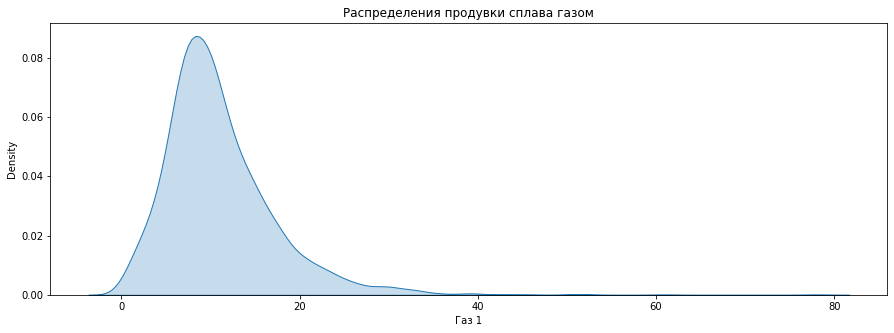

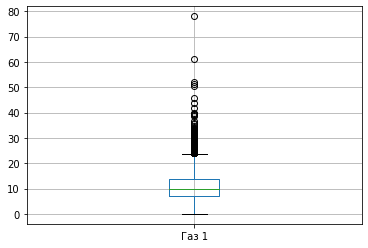

In [30]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(data_gas['Газ 1'], legend=True,shade=True)
plt.title('Распределения продувки сплава газом')
plt.show()
fig2 =data_gas.boxplot('Газ 1')

Пропуски отсутсвуют

key не повторяется

Распределение в норме

# Результаты измерения температуры

In [31]:
data_temp=pd.read_csv('/datasets/data_temp_new.csv')

In [32]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [33]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


необходимо изменить формат времени

не по всем замерам есть данные по температуре

In [34]:
data_temp['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

Видим что по некоторым партиям было несоклько замеров, также видим что в некоторых строках не заполнена температура

In [35]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

In [36]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


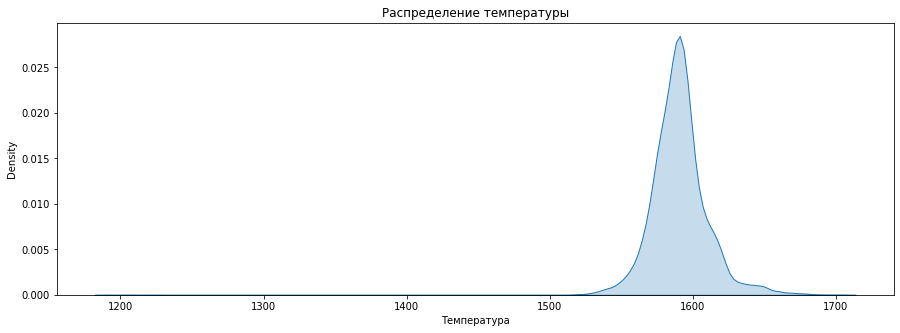

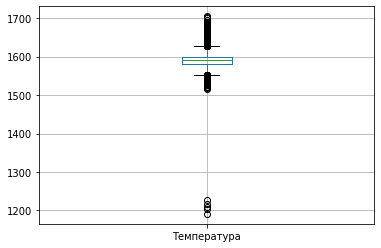

In [37]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(data_temp['Температура'], legend=True,shade=True)
plt.title('Распределение температуры')
plt.show()
fig2 =data_temp.boxplot('Температура')

График имеет нормальное распределение, также видим некороые выбросы в диапазонах до 1300 и после 1600. 

Температура плавления стали ~ 1550 градусов

# Данные о проволочных материалах (объём)

In [38]:
data_wire=pd.read_csv('/datasets/data_wire_new.csv')

In [39]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [41]:
data_wire['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

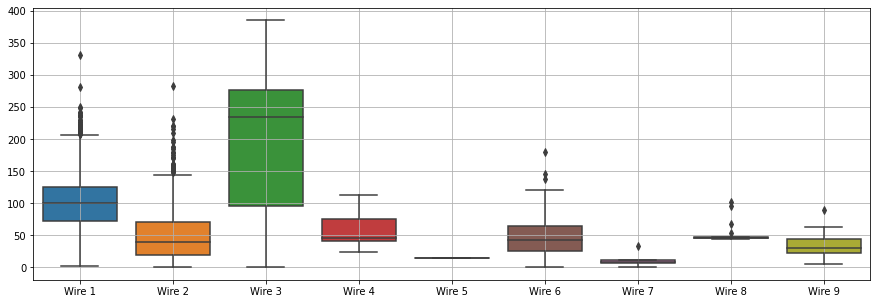

In [42]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_wire.drop('key', axis=1))
plt.grid();

В данных имеются пропуски

необходимо изменить формат даты

In [43]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

#  Данные о проволочных материалах (время).

In [44]:
data_wire_time=pd.read_csv('/datasets/data_wire_time_new.csv')

In [45]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [47]:
#к.р.
data_wire_time = data_wire_time.set_index('key')
data_wire_time = data_wire_time.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
data_wire_time = data_wire_time.reset_index()

In [48]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


data_wire_time['Wire 1'] = pd.to_datetime(data_wire_time['Wire 1'], format='%Y-%m-%dT%H:%M:%S')
data_wire_time['Wire 2'] = pd.to_datetime(data_wire_time['Wire 2'], format='%Y-%m-%dT%H:%M:%S')
data_wire_time['Wire 3'] = pd.to_datetime(data_wire_time['Wire 3'], format='%Y-%m-%dT%H:%M:%S')
data_wire_time['Wire 4'] = pd.to_datetime(data_wire_time['Wire 4'], format='%Y-%m-%dT%H:%M:%S')
data_wire_time['Wire 5'] = pd.to_datetime(data_wire_time['Wire 5'], format='%Y-%m-%dT%H:%M:%S')
data_wire_time['Wire 6'] = pd.to_datetime(data_wire_time['Wire 6'], format='%Y-%m-%dT%H:%M:%S')
data_wire_time['Wire 7'] = pd.to_datetime(data_wire_time['Wire 7'], format='%Y-%m-%dT%H:%M:%S')
data_wire_time['Wire 8'] = pd.to_datetime(data_wire_time['Wire 8'], format='%Y-%m-%dT%H:%M:%S')
data_wire_time['Wire 9'] = pd.to_datetime(data_wire_time['Wire 9'], format='%Y-%m-%dT%H:%M:%S')

In [49]:
data_wire_time['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

Имеются пропуски

key не повторяется

# 

1 Вывод


Столбцы на разных языках. Имена столбцов нужно превести к общепринятому виду (английским языком, прописными буквами и без пробелов).

Во всех столбцах фреймов _date необходим перевод времени в формат datetime. Что мы и сделали сразу при выгрузке данных)

Есть столбцы, которые могут не использовать тип float, так как хранят только целые числа.

Целевым признаком будет последний замер температуры в data_temp

Пропуски в столбцах могут быть по разным причинам: ошибка переноса, ошибка датчика или же просто остутсвие необходимости в проведении действия (нагрев, добавка присадок и пр.)

Данные требуют групировки по нормеру партии key, также небходимо поправить все вышеперечисленные замечания.

# Предобработка данных

Приведем столбцы датасета к единому формату

In [50]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
data_gas.columns = ['key', 'gas_1']
data_temp.columns = ['key', 'time','temp']
data_bulk.columns = data_bulk.columns.str.replace(r"([A-Z])", r"\1").str.lower().str.replace(' ', '_').str.strip()
data_bulk_time.columns = data_bulk_time.columns.str.replace(r"([A-Z])", r"\1").str.lower().str.replace(' ', '_').str.strip()
data_wire.columns = data_wire.columns.str.replace(r"([A-Z])", r"\1").str.lower().str.replace(' ', '_').str.strip()
data_wire_time.columns = data_wire_time.columns.str.replace(r"([A-Z])", r"\1").str.lower().str.replace(' ', '_').str.strip()
#data_wire_time.columns

# Данные об электродах

In [51]:
data_arc = data_arc.query('reactive_power > 0')

In [52]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14875 non-null  int64         
 1   start_time      14875 non-null  datetime64[ns]
 2   end_time        14875 non-null  datetime64[ns]
 3   active_power    14875 non-null  float64       
 4   reactive_power  14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


# Данные о подаче сыпучих материалов (объём)

Заменяем NaN на 0

In [53]:
data_bulk= data_bulk.fillna(0)

In [54]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


# Данные о подаче сыпучих материалов (время)

Заменяем NaN на 0

In [55]:
data_bulk_time= data_bulk_time.fillna(0)

In [56]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   3129 non-null   object
 2   bulk_2   3129 non-null   object
 3   bulk_3   3129 non-null   object
 4   bulk_4   3129 non-null   object
 5   bulk_5   3129 non-null   object
 6   bulk_6   3129 non-null   object
 7   bulk_7   3129 non-null   object
 8   bulk_8   3129 non-null   object
 9   bulk_9   3129 non-null   object
 10  bulk_10  3129 non-null   object
 11  bulk_11  3129 non-null   object
 12  bulk_12  3129 non-null   object
 13  bulk_13  3129 non-null   object
 14  bulk_14  3129 non-null   object
 15  bulk_15  3129 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [57]:
data_bulk_time.isna().sum()

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

# Данные о продувке сплава газом

In [58]:
data_gas.isna().sum()

key      0
gas_1    0
dtype: int64

# Результаты измерения температуры

In [59]:
data_temp.isna().sum()

key        0
time       0
temp    3427
dtype: int64

удаляю все строки с партиями, где нет данных по финишной температуре

In [60]:
key_NaN = data_temp[data_temp['temp'].isna()]['key'].unique()
data_temp = data_temp[~data_temp['key'].isin(key_NaN)]
data_temp

,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [61]:
data_temp.isna().sum()

key     0
time    0
temp    0
dtype: int64

# Данные о проволочных материалах (объём)

In [62]:
data_wire=data_wire.fillna(0)

In [63]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


# Данные о проволочных материалах (время).

In [64]:
data_wire_time=data_wire_time.fillna(0)

In [65]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3081 non-null   object
 2   wire_2  3081 non-null   object
 3   wire_3  3081 non-null   object
 4   wire_4  3081 non-null   object
 5   wire_5  3081 non-null   object
 6   wire_6  3081 non-null   object
 7   wire_7  3081 non-null   object
 8   wire_8  3081 non-null   object
 9   wire_9  3081 non-null   object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Все пропуски обработаны


# Подготовка данных

Вычисляем время нагрева

In [66]:
data_arc['delta-time, sec'] = (data_arc['end_time'] - data_arc['start_time']).dt.seconds

In [67]:
data_arc

,key,start_time,end_time,active_power,reactive_power,"delta-time, sec"
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57


Вычисляем энергию

In [68]:
data_arc['energy'] = data_arc['delta-time, sec'] * data_arc['active_power']
data_arc

,key,start_time,end_time,active_power,reactive_power,"delta-time, sec",energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,128.335684
...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157,69.038395
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180,116.369640
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184,191.309584
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57,30.225219


Оставляем данные только по затраченной энергии

In [69]:
data_arc = data_arc.groupby('key').agg({'energy': sum})
data_arc

,energy
key,
1,628.616930
2,395.281800
3,581.774624
4,543.710274
5,412.180480
...,...
3237,493.152191
3238,229.390861
3239,751.674870


Объединяем все в одну таблицу

In [70]:
data_target= data_temp.groupby(by = 'key', as_index = False).agg(['first', 'last'])

In [71]:
data_target.columns = ['time_first', 'time_last', 'temp_first', 'temp_last']

In [72]:
data_target=data_target.drop(['time_first', 'time_last'], axis=1)

In [73]:
data_final = data_target.merge(right=data_arc,
                       how='inner',
                       on='key')\
                .merge(right=data_bulk,
                       how='inner',
                       on='key')\
                .merge(right=data_gas,
                       how='inner',
                       on='key')\
                .merge(right=data_wire,
                       how='inner',
                       on='key')

data_final

,key,temp_first,temp_last,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,628.616930,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,395.281800,0.0,0.0,0.0,73.0,0.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,581.774624,0.0,0.0,0.0,34.0,0.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,543.710274,0.0,0.0,0.0,81.0,0.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,412.180480,0.0,0.0,0.0,78.0,0.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,571.539318,0.0,0.0,21.0,0.0,0.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,2496,1554.0,1591.0,675.222467,0.0,0.0,0.0,63.0,0.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,2497,1571.0,1589.0,680.326674,0.0,0.0,0.0,85.0,0.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,2498,1591.0,1594.0,474.918795,0.0,0.0,90.0,0.0,0.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
#к.р.
data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
key,2329.0,1251.832546,714.762400,1.000000,630.000000,1255.000000,1868.000000,2499.000000
temp_first,2329.0,1586.718763,28.290792,1191.000000,1571.000000,1587.000000,1603.000000,1660.000000
temp_last,2329.0,1593.365393,11.200915,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
energy,2329.0,538.967370,257.314897,26.187544,368.130458,508.068106,678.323372,3718.054401
bulk_1,2329.0,3.427651,12.412132,0.000000,0.000000,0.000000,0.000000,185.000000
bulk_2,2329.0,1.422499,19.082119,0.000000,0.000000,0.000000,0.000000,325.000000
bulk_3,2329.0,47.348218,75.310430,0.000000,0.000000,0.000000,80.000000,454.000000
bulk_4,2329.0,37.303564,58.643238,0.000000,0.000000,0.000000,77.000000,281.000000
bulk_5,2329.0,2.640189,22.402293,0.000000,0.000000,0.000000,0.000000,603.000000
bulk_6,2329.0,22.430228,55.790873,0.000000,0.000000,0.000000,0.000000,503.000000


In [75]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2329 non-null   int64  
 1   temp_first  2329 non-null   float64
 2   temp_last   2329 non-null   float64
 3   energy      2329 non-null   float64
 4   bulk_1      2329 non-null   float64
 5   bulk_2      2329 non-null   float64
 6   bulk_3      2329 non-null   float64
 7   bulk_4      2329 non-null   float64
 8   bulk_5      2329 non-null   float64
 9   bulk_6      2329 non-null   float64
 10  bulk_7      2329 non-null   float64
 11  bulk_8      2329 non-null   float64
 12  bulk_9      2329 non-null   float64
 13  bulk_10     2329 non-null   float64
 14  bulk_11     2329 non-null   float64
 15  bulk_12     2329 non-null   float64
 16  bulk_13     2329 non-null   float64
 17  bulk_14     2329 non-null   float64
 18  bulk_15     2329 non-null   float64
 19  gas_1       2329 non-null  

In [77]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2329 non-null   int64  
 1   temp_first  2329 non-null   float64
 2   temp_last   2329 non-null   float64
 3   energy      2329 non-null   float64
 4   bulk_1      2329 non-null   float64
 5   bulk_2      2329 non-null   float64
 6   bulk_3      2329 non-null   float64
 7   bulk_4      2329 non-null   float64
 8   bulk_5      2329 non-null   float64
 9   bulk_6      2329 non-null   float64
 10  bulk_7      2329 non-null   float64
 11  bulk_8      2329 non-null   float64
 12  bulk_9      2329 non-null   float64
 13  bulk_10     2329 non-null   float64
 14  bulk_11     2329 non-null   float64
 15  bulk_12     2329 non-null   float64
 16  bulk_13     2329 non-null   float64
 17  bulk_14     2329 non-null   float64
 18  bulk_15     2329 non-null   float64
 19  gas_1       2329 non-null  

Проверим температуру на выбросы, для этого построим график


<AxesSubplot:>

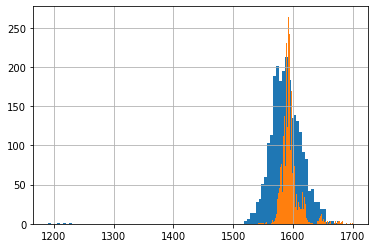

In [78]:
data_target["temp_first"].hist(bins = 100)
data_target["temp_last"].hist(bins = 100)

In [79]:
data_target = data_target.query('temp_first > 1500')

<AxesSubplot:>

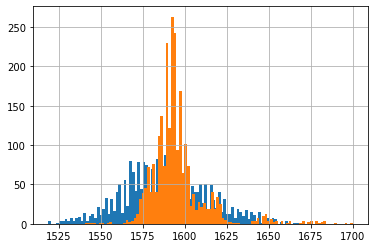

In [80]:
data_target["temp_first"].hist(bins = 100)
data_target["temp_last"].hist(bins = 100)

Посмотрим корреляцию

Text(0.5, 1.0, 'Тепловая карта матрицы корреляций')

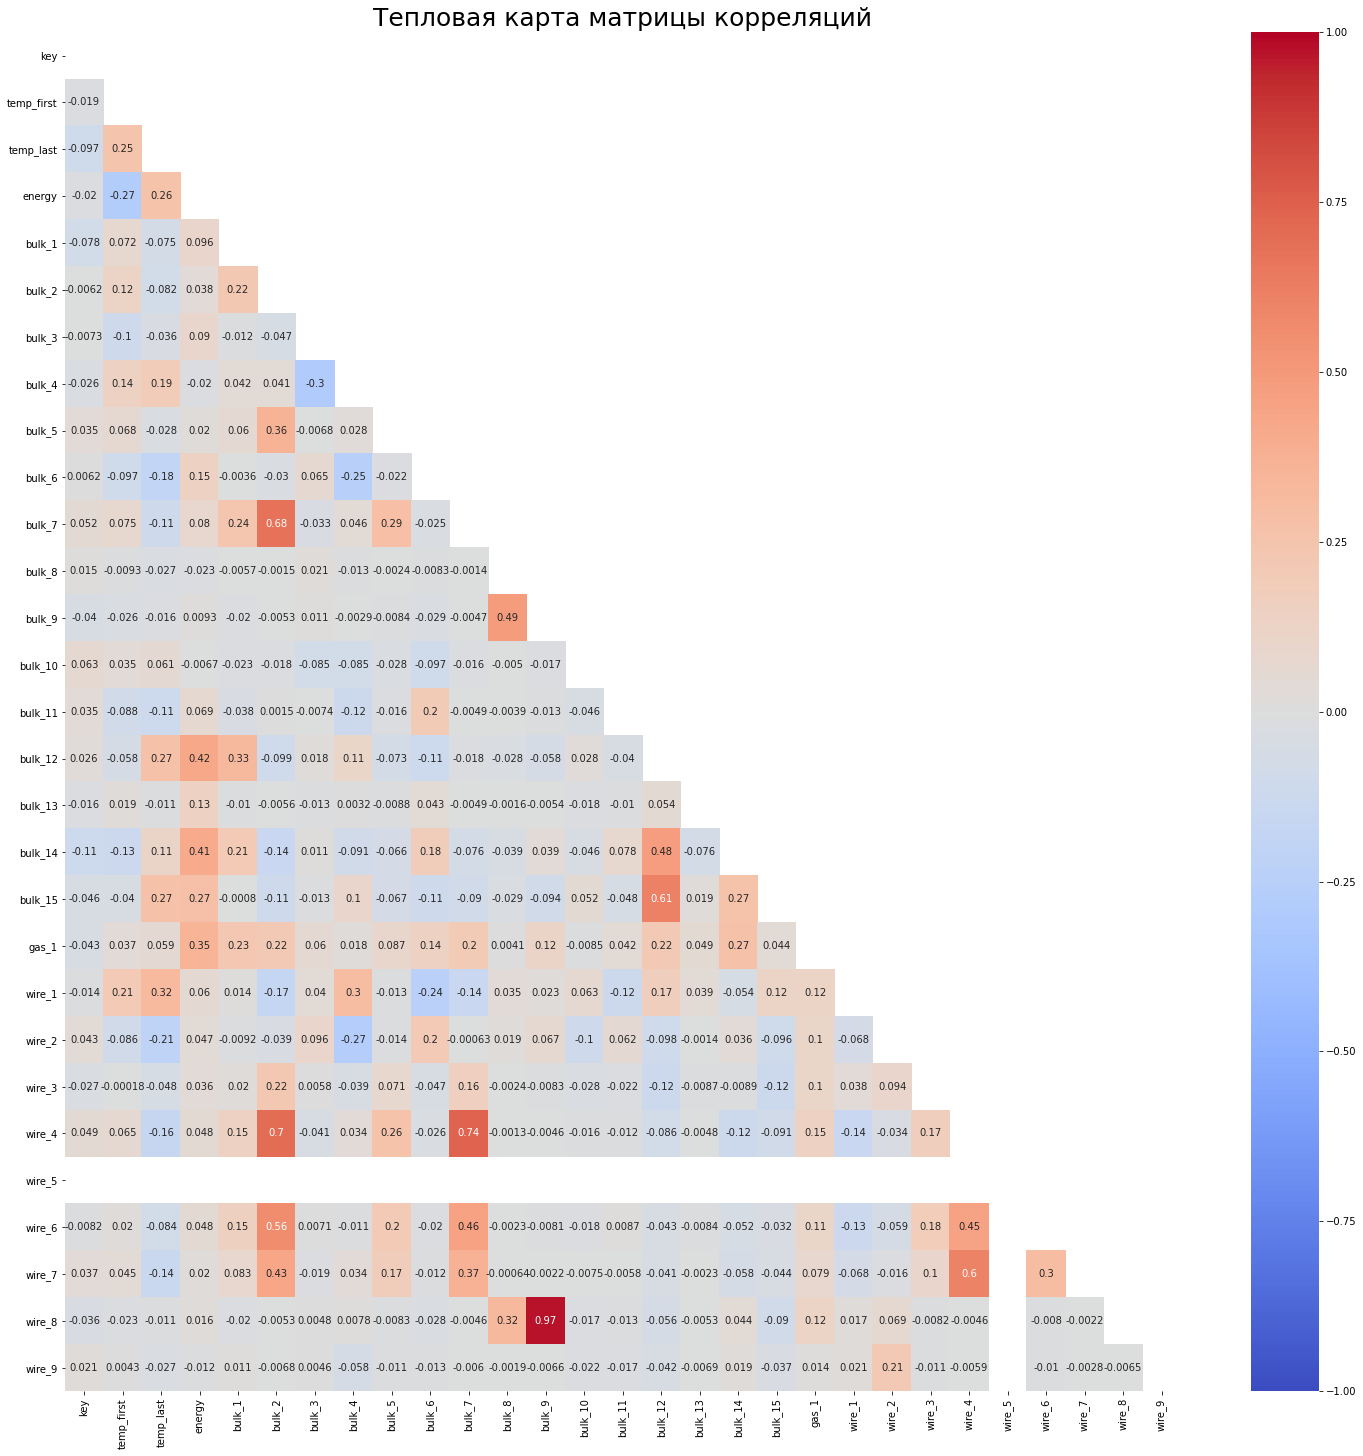

In [81]:
plt.figure(figsize=(25, 25))
upp_mat = np.triu(data_final.corr())
heatmap=sns.heatmap(data_final.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)
heatmap.set_title('Тепловая карта матрицы корреляций', fontsize=25)

In [82]:
data_final.corr()['temp_last'].sort_values(ascending=False)[1:]

wire_1        0.317575
bulk_12       0.267424
bulk_15       0.266414
energy        0.258558
temp_first    0.252443
bulk_4        0.187970
bulk_14       0.114617
bulk_10       0.061350
gas_1         0.059160
wire_8       -0.010767
bulk_13      -0.010920
bulk_9       -0.016075
bulk_8       -0.026587
wire_9       -0.027488
bulk_5       -0.028355
bulk_3       -0.035977
wire_3       -0.047537
bulk_1       -0.075206
bulk_2       -0.082454
wire_6       -0.084034
key          -0.097242
bulk_7       -0.107275
bulk_11      -0.114753
wire_7       -0.137262
wire_4       -0.159719
bulk_6       -0.181816
wire_2       -0.206672
wire_5             NaN
Name: temp_last, dtype: float64

Целевой признак сильнее коррелирует с:

wire_1        0.317575
bulk_12       0.267424
bulk_15       0.266414
energy        0.258558
temp_first    0.252443

прямо пропорционально, но даже с ними зависимость не слишком большая

Обратно пропорционально целевой признак связан сильнее всего с Wire 2,bulk_6,  Wire 4,  но также не слишком сильно.


Так как отсутсвуют данные по wire_5 нет данных, удаляем его

In [83]:
data_final = data_final.drop(['wire_5'], axis = 1)

Разобьем на выборки

In [84]:
random_state=15823

In [85]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2329 non-null   int64  
 1   temp_first  2329 non-null   float64
 2   temp_last   2329 non-null   float64
 3   energy      2329 non-null   float64
 4   bulk_1      2329 non-null   float64
 5   bulk_2      2329 non-null   float64
 6   bulk_3      2329 non-null   float64
 7   bulk_4      2329 non-null   float64
 8   bulk_5      2329 non-null   float64
 9   bulk_6      2329 non-null   float64
 10  bulk_7      2329 non-null   float64
 11  bulk_8      2329 non-null   float64
 12  bulk_9      2329 non-null   float64
 13  bulk_10     2329 non-null   float64
 14  bulk_11     2329 non-null   float64
 15  bulk_12     2329 non-null   float64
 16  bulk_13     2329 non-null   float64
 17  bulk_14     2329 non-null   float64
 18  bulk_15     2329 non-null   float64
 19  gas_1       2329 non-null  

In [86]:
features = data_final.drop(['temp_last', 'key'], axis=1)
target = data_final['temp_last']

In [87]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=15823)

In [88]:
numeric = features_train.select_dtypes(exclude='object').columns.to_list()
numeric = [i for i in numeric if i not in ("temp_last")]
scaler = MinMaxScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()

,temp_first,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,...,bulk_15,gas_1,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
674,0.754797,0.215745,0.0,0.0,0.363436,0.282609,0.0,0.0,0.0,0.0,...,0.000000,0.092947,0.334372,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2251,0.805970,0.072922,0.0,0.0,0.229075,0.000000,0.0,0.0,0.0,0.0,...,0.261728,0.069700,0.142552,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
323,0.831557,0.130883,0.0,0.0,0.000000,0.206522,0.0,0.0,0.0,0.0,...,0.498765,0.069663,0.348966,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1748,0.810235,0.203133,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.158483,0.414848,0.276237,0.0,0.0,0.0,0.0,0.0,0.0
1942,0.865672,0.151065,0.0,0.0,0.154185,0.000000,0.0,0.0,0.0,0.0,...,0.511111,0.119759,0.218324,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
print(features_train.shape)
print(features_test.shape)

(1746, 26)
(583, 26)


Вывод: Данные подготовлены, тестовая выборка составляет - 25%, random_state принят 15823

# Обучение моделей

Для расчёта целевой метрики используем  MAE напишем функцию.

In [90]:
def MAE(target, predict):
    return (mean_absolute_error(target, predict))
   
MAE_score = make_scorer(MAE, greater_is_better=False)

Линейная регрессия

In [91]:
model_lr=LinearRegression()
model_lr.fit(features_train,target_train)

LinearRegression()

In [92]:
#Определяю RMSE модели с помощью кросс-валидации
regression_cv_score = pd.Series(cross_val_score(model_lr,features_train,target_train,scoring=MAE_score,cv=7)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)


Среднее качество модели линейной регрессии на кросс-валидации: 6.901103681643896


In [93]:
target_predict = model_lr.predict(features_train) 

Обучаем лес решений:

In [94]:
model_rf = RandomForestRegressor(random_state=15823, criterion='mse',warm_start=False, n_estimators=100)
model_rf.fit(features_train, target_train)

RandomForestRegressor(criterion='mse', random_state=15823)

In [95]:
#Объявляю модель
forest = RandomForestRegressor()
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(5, 15, 5),
                     'max_depth': range(1, 6, 2),
                     'min_samples_leaf': range(1,4),
                     'min_samples_split': range(2,6,2) }

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring=MAE_score, cv=3)
forest_grid.fit(features_train, target_train)
fbs=forest_grid.best_score_*(-1)
print(forest_grid.best_estimator_)
print(forest_grid.best_params_)
print('Качество модели на кросс-валидации', fbs)

RandomForestRegressor(max_depth=5, min_samples_leaf=3, n_estimators=10)
{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
Качество модели на кросс-валидации 6.795849515946153


In [96]:
target_predict_forest= model_rf.predict(features_train) 

Обучаем ансамбль моделей LGBMRegressor

In [97]:
model_LGB = lgb.LGBMRegressor()
model_LGB.fit(features_train, target_train)

LGBMRegressor()

Определяем оптимальные гиперпараметры и качество модели на кросс-валидации

In [98]:
#Объявляю модель
lg = lgb.LGBMRegressor()
#Определяю словарь с набором параметров
lg_parametrs = {"max_depth": [5,7,10], "learning_rate" : [0.01, 0.1], "num_leaves": [127],"n_estimators": range (5,10,2)}
#Применяю GridSearchCV с кросс-валидацией
lg_grid = GridSearchCV(lg, lg_parametrs, scoring=MAE_score, cv=3, verbose=True)
lg_grid.fit(features_train, target_train)
lbs=lg_grid.best_score_*(-1)
print(lg_grid.best_estimator_)
print(lg_grid.best_params_)
print('Качество модели на кросс-валидации', lbs)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
LGBMRegressor(max_depth=10, n_estimators=9, num_leaves=127)
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 9, 'num_leaves': 127}
Качество модели на кросс-валидации 6.9541809840678


In [99]:
target_predict_lgr= model_LGB.predict(features_train) 

Обучаем ансамбль моделей CatBoostRegressor

In [100]:
model_cat = CatBoostRegressor(loss_function='MAE',silent=True, random_seed=15823)
start = time.time()
model_cat.fit(features_train, target_train)

In [101]:
cbr = CatBoostRegressor(loss_function='MAE',silent=True, random_seed=15823)
cbr_params = {'learning_rate': np.logspace(-3, 0, 5),'iterations': range(20, 60, 20),'depth': range(5,10,2)}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=3, scoring=MAE_score)
grid_cbr.fit(features_train, target_train);
cbs=grid_cbr.best_score_*(-1)
print(grid_cbr.best_estimator_)
print(grid_cbr.best_params_)
print('Качество модели на кросс-валидации', cbs)

{'depth': 5, 'iterations': 40, 'learning_rate': 0.1778279410038923}
Качество модели на кросс-валидации 6.636837744760716


In [103]:
target_predict_cbr= model_cat.predict(features_train) 

Сводная таблица

In [105]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'LGBMRegressor',
         'CatBoostRegressor']
data = {'MAE на CV':[regression_cv_score,
                      fbs,
                      lbs,
                      cbs]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг MAE на CV'] = (scores_data['MAE на CV'].min() /
                              scores_data['MAE на CV'])
scores_data['Выполнение задачи'] = scores_data['MAE на CV'] <= 6.8
scores_data

,MAE на CV,Рейтинг MAE на CV,Выполнение задачи
LinearRegression,6.901104,0.961707,False
RandomForestRegressor,6.795850,0.976602,True
LGBMRegressor,6.954181,0.954367,False
CatBoostRegressor,6.636838,1.000000,True


В лидерах у нас модель CatBoostRegressor с MAE = 6.63. Проведем на ней тестирование.

# Тестирование модели

In [106]:

#Для проверки адекватности моделей создаю константную модель
const_model = pd.Series(target_test.median(), index=target_test.index)

#Определяю метрику MAE константной модели
const_MAE = round(MAE(target_test, const_model),10)
print('MAE для константной модели', const_MAE)

MAE для константной модели 8.1320754717


In [107]:
column=['Качество модели','Скорость обучения, s','Скорость предсказания, s','Рейтинг']

comparison_tabl = pd.DataFrame(index=['Качество модели','Рейтинг'], columns=['LinearRegression','RandomForestRegressor','LightGBM', 'CatBoostRegressor'])
comparison_tabl['LinearRegression'] = regression_cv_score, (regression_cv_score/const_MAE)*100
comparison_tabl['RandomForestRegressor'] = fbs, (fbs/const_MAE)*100
comparison_tabl['LightGBM'] = lbs, (lbs/const_MAE)*100
comparison_tabl['CatBoostRegressor'] = cbs, (cbs/const_MAE)*100
comparison_tabl

,LinearRegression,RandomForestRegressor,LightGBM,CatBoostRegressor
Качество модели,6.901104,6.795850,6.954181,6.636838
Рейтинг,84.862760,83.568451,85.515451,81.613086


Исходя из данных таблицы лучшей моделью признаем CatBoostRegressor. Проводим тест на ней

In [108]:
target_predict=model_cat.predict(features_test)

In [109]:
print('MAE',round(mean_absolute_error(target_test, target_predict),2))

MAE 6.39


Оценим вжность факторов в модели

Learning rate set to 0.044712
0:	learn: 10.9774750	total: 3.34ms	remaining: 3.33s
1:	learn: 10.8681410	total: 6.61ms	remaining: 3.3s
2:	learn: 10.7626005	total: 9.98ms	remaining: 3.32s
3:	learn: 10.6512399	total: 13.4ms	remaining: 3.34s
4:	learn: 10.5525532	total: 16.5ms	remaining: 3.29s
5:	learn: 10.4591962	total: 20.8ms	remaining: 3.44s
6:	learn: 10.3641229	total: 25.5ms	remaining: 3.62s
7:	learn: 10.2675280	total: 28.7ms	remaining: 3.55s
8:	learn: 10.1735502	total: 33.8ms	remaining: 3.72s
9:	learn: 10.0863420	total: 38.5ms	remaining: 3.81s
10:	learn: 10.0101808	total: 43.1ms	remaining: 3.87s
11:	learn: 9.9336793	total: 48.2ms	remaining: 3.97s
12:	learn: 9.8679000	total: 53.1ms	remaining: 4.03s
13:	learn: 9.7967097	total: 57.9ms	remaining: 4.08s
14:	learn: 9.7308227	total: 62.5ms	remaining: 4.1s
15:	learn: 9.6653474	total: 65.7ms	remaining: 4.04s
16:	learn: 9.6078028	total: 70.2ms	remaining: 4.06s
17:	learn: 9.5492648	total: 74.7ms	remaining: 4.07s
18:	learn: 9.4883490	total: 79.3ms	

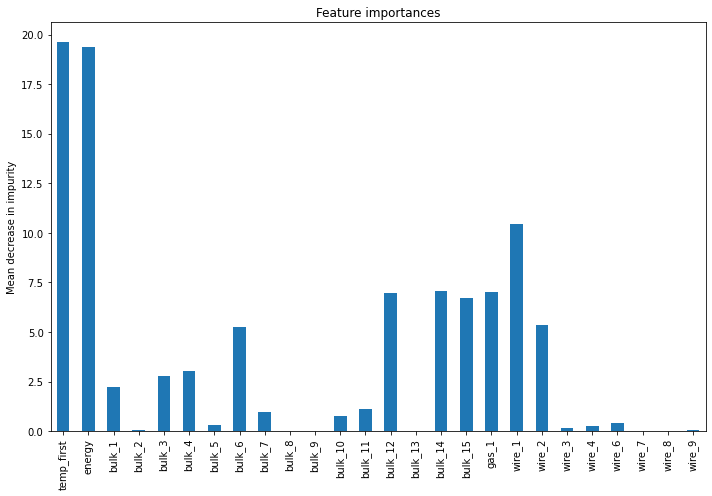

In [110]:
feature_names = features_train.columns 
model = CatBoostRegressor()
model.fit(features_train, target_train)
pred = model.predict(features_test)
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([model.feature_importances_], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Из полученного графика видно, что на финальную температуру в большей степени влияют:

Начальная температура

wire_1
wire_2
bulk_15
bulk_14
bulk_12
gas_1

# Вывод

Для предсказаний выбрала модели:
LinearRegression
RandomForestRegressor
LGBMRegressor
CatBoostRegressor
с масштабированием и кросс-валидацией.

Наилучший результат MAE дала CatBoostRegressor модель, которая на обучающей выборке  дала MAE = 6.63, на тестовой выборке дала MAE = 6.39. При этом на целевой признак более всего влияют признаки начальная тепература wire_1, gas_1, bulk_15, wire_2, bulk_12

Проверку на вменяемость модель прошла.


Таким образом, для предсказания температуры сплава (а следовательно, потерь электроэнергии) подойдет CatBoostRegressor, которая ошибается на 6.63 градуса

# Отчет

# 1. Выполнение плана

В ходе выполнения проекта были выолнены все ранее запланированные пункты первоначального плана. Не была использована валидационная выборка, т.к. использовали кросс-валидацию.

# 2. Трудности 

1. Специфика техпроцесса. При вебинре с тимлидом закрыылись многие вопросы.
2. Пропуски в замерах температуры и выбросы, т.к. это основной показатель пришлось удалять строки с отсутсвием данных.

# 3. Ключевые шаги в решении задачи

Ключевыми шагами в решении задачи стали блоки:

1. Анализ данных 
2. Очистка и заполнение данных, что обеспечило более качественный анализ и лучшую работу моделей.
3. Обучение моделей.
4. Выбор лучшей по показателю MAE. 
5. Для поиска наилучшего показателя MAE были обучены 4 модели.
6. Протестирована модель с наименьшей MAE

# 4. Признаки для обучения модели и  предобработка  признаков

1. Разбили на обучающую и тестовую 75/25
2. Целевым признаком выбрана вторая(конечная) температура 
3. Удалили строки с пропуском конечной температуры
4. Удалили выбросы начальной температуры

# 5. Итоговая модель

Итоговой моделью была выбрана  CatBoostRegressor - модель с наименьшей MAE среди обученных. MAE  CatBoostRegressor = 6.63, это означает, что модель ошибается на 6.63 градуса при прогнозировании.

Модель имеет следующие гиперпараметры:{'depth': 5, 'iterations': 40, 'learning_rate': 0.1778279410038923}

При этом легирующие добавки wire_1, wire_2, bulk_15, bulk_12 как минимум, не снижают температуру, то есть при подаче этих легирующих материалов температура не падает, следовательно, не требуется дополнительная энергия на нагрев. А при подаче wire_2 характерно остывание. Таким образом, при планировании варок необходимо учитывать эти моменты

# Вопросы

1. Выбираем ли мы сами модели?
2. Будут ли еще какие - либо вхоящие данные по тех. процессу?